# Deciding neighborhood to live in Aachen depending on age group

### Business Problem

The problem statement is to find a suitable Stadtbezirke (municipalities) to live in Aachen depending on age group by analyzing venues in that region. As different age groups have different lifestyle and requirements, in general they tend to choose specific neighborhoods, which have all the amenities that support their lifestyle. The categories of age groups, that will be considered here are Students (18-30), Working People (31-50), Older citizens (50+). 

### Data 

The data to be used for this problem will be as follows:

1. Open data from state of Nordrhein-Westfalen (https://open.nrw/)
    * it will be used to collect names of different municipality regions in Aachen city and coordinates will be aquired to retrieve foursquare location data.
2. foursquare location data
    * The information of different business venues along with public services like parks, hospitals, universities.
    * All the venue information can be used to cluster the municipalities into different requirements for specific age groups.
     e.g: people in the age group 15-30 like clubing and go to university. so the areas having more clubs and university buildings will choose that place for their residence. Similarly older people above age 50 will like to have park and medical facilities close to their residence. 

### Data Collection

Collect location coordinates from google using the location names we already got from open.nrw

In [1]:
# Import Libraries
import pandas as pd
from geopy import geocoders
import folium
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import seaborn as sns
from bs4 import BeautifulSoup
import requests
import numpy as np
import math

1. Import Stadtbezirke data in to pandas data frame 

In [2]:
source = requests.get('https://postal-codes.cybo.com/germany/aachen/#listcodes').text
soup = BeautifulSoup(source, "lxml")
table = soup.find("table", {"class":"paleblue"})
table_rows = table.find_all('tr')

res = []
for tr in table_rows:
    td = tr.find_all('td')
    row = [tr.text.strip() for tr in td if tr.text.strip()]
    if row:
        res.append(row)
res

[['52062', 'Aachen', 'North Rhine-Westphalia', '8,152', '1.576 km²'],
 ['52064', 'Aachen', 'North Rhine-Westphalia', '10,981', '2.017 km²'],
 ['52066', 'Aachen', 'North Rhine-Westphalia', '20,958', '7.5 km²'],
 ['52068', 'Aachen', 'North Rhine-Westphalia', '22,000', '5.6 km²'],
 ['52070', 'Aachen', 'North Rhine-Westphalia', '26,939', '9.1 km²'],
 ['52072', 'Aachen', 'North Rhine-Westphalia', '21,712', '19.3 km²'],
 ['52074', 'Aachen', 'North Rhine-Westphalia', '36,959', '33.4 km²'],
 ['52076', 'Aachen', 'North Rhine-Westphalia', '24,587', '55.1 km²'],
 ['52078', 'Aachen', 'North Rhine-Westphalia', '30,463', '12.5 km²'],
 ['52080', 'Aachen', 'North Rhine-Westphalia', '24,343', '15.1 km²']]

In [3]:
# Put the information in a DataFrame
aachen_df = pd.DataFrame(res, columns=['postcode', 'city', 'state', 'population', 'area'])
aachen_df

,postcode,city,state,population,area
0,52062,Aachen,North Rhine-Westphalia,"8,152",1.576 km²
1,52064,Aachen,North Rhine-Westphalia,"10,981",2.017 km²
2,52066,Aachen,North Rhine-Westphalia,"20,958",7.5 km²
3,52068,Aachen,North Rhine-Westphalia,"22,000",5.6 km²
4,52070,Aachen,North Rhine-Westphalia,"26,939",9.1 km²
5,52072,Aachen,North Rhine-Westphalia,"21,712",19.3 km²
6,52074,Aachen,North Rhine-Westphalia,"36,959",33.4 km²
7,52076,Aachen,North Rhine-Westphalia,"24,587",55.1 km²
8,52078,Aachen,North Rhine-Westphalia,"30,463",12.5 km²
9,52080,Aachen,North Rhine-Westphalia,"24,343",15.1 km²


In [4]:
geolocator = geocoders.Nominatim(user_agent="nuaaichi_aachen")
loc_lat_lng = []
for postcode, ar in zip(aachen_df['postcode'], aachen_df['area']):
    loc = geolocator.geocode({'postalcode':postcode})
    loc_lat_lng.append((loc.latitude, loc.longitude, math.floor(math.sqrt(float(ar.split(' ')[0])/3.14)*1000 )))

loc_lat_lng = list(zip(*loc_lat_lng))
aachen_df['lat'], aachen_df['lng'], aachen_df['radius']= loc_lat_lng
aachen_df

,postcode,city,state,population,area,lat,lng,radius
0,52062,Aachen,North Rhine-Westphalia,"8,152",1.576 km²,50.776348,6.077642,708
1,52064,Aachen,North Rhine-Westphalia,"10,981",2.017 km²,50.769547,6.080325,801
2,52066,Aachen,North Rhine-Westphalia,"20,958",7.5 km²,50.762723,6.107663,1545
3,52068,Aachen,North Rhine-Westphalia,"22,000",5.6 km²,50.780074,6.121386,1335
4,52070,Aachen,North Rhine-Westphalia,"26,939",9.1 km²,50.791070,6.096156,1702
5,52072,Aachen,North Rhine-Westphalia,"21,712",19.3 km²,50.817683,6.047362,2479
6,52074,Aachen,North Rhine-Westphalia,"36,959",33.4 km²,50.766230,6.041954,3261
7,52076,Aachen,North Rhine-Westphalia,"24,587",55.1 km²,50.709571,6.193844,4189
8,52078,Aachen,North Rhine-Westphalia,"30,463",12.5 km²,50.761230,6.136976,1995
9,52080,Aachen,North Rhine-Westphalia,"24,343",15.1 km²,50.784631,6.160787,2192


In [5]:
# Getting the coordinates of Aachen
location = geolocator.geocode("Aachen")
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Aachen are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Aachen are 50.776351, 6.083862.


In [6]:
map_aachen = folium.Map(location=[latitude, longitude], zoom_start=11)

for lat, lng, pcode in zip(aachen_df['lat'], aachen_df['lng'], aachen_df['postcode']):
    label = '{}'.format(pcode)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_aachen)  
    
map_aachen

Add Foursqare credentials to find information about the locations

In [51]:
CLIENT_ID = '*******'
CLIENT_SECRET = '******'
VERSION = '20200521' # Foursquare API version

Collecting the Categories of Venues, which will help us choose places for different age groups

In [8]:
categories_url = 'https://api.foursquare.com/v2/venues/categories?client_id={}&client_secret={}&v={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
            
# make the GET request
results = requests.get(categories_url).json()

In [9]:
len(results['response']['categories'])

10

Following are the top level categories from Foursquare

In [10]:
categories_list = []
# Let's print only the top-level categories and their IDs and also add them to categories_list

def print_categories(categories, level=0, max_level=0):    
    if level>max_level: return
    out = ''
    out += '-'*level
    for category in categories:
        print(out + category['name'] + ' (' + category['id'] + ')')
        print_categories(category['categories'], level+1, max_level)
        categories_list.append((category['name'], category['id']))
        
print_categories(results['response']['categories'], 0, 0)

Arts & Entertainment (4d4b7104d754a06370d81259)
College & University (4d4b7105d754a06372d81259)
Event (4d4b7105d754a06373d81259)
Food (4d4b7105d754a06374d81259)
Nightlife Spot (4d4b7105d754a06376d81259)
Outdoors & Recreation (4d4b7105d754a06377d81259)
Professional & Other Places (4d4b7105d754a06375d81259)
Residence (4e67e38e036454776db1fb3a)
Shop & Service (4d4b7105d754a06378d81259)
Travel & Transport (4d4b7105d754a06379d81259)


Function to get counts of the venues in each category from foursquare for each of our locations in a particular region

In [11]:
def get_venues_count(lat, lng, radius, categoryId):
    explore_url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&radius={}&categoryId={}'.format(
                CLIENT_ID, 
                CLIENT_SECRET, 
                VERSION,
                lat,
                lng,
                radius,
                categoryId)

    # make the GET request
    return requests.get(explore_url).json()['response']['totalResults']

In [12]:
#Create new dataframe to store venues data
aachen_venues_df = aachen_df.copy()
for c in categories_list:
    aachen_venues_df[c[0]] = 0

In [13]:
#Request number of venues, store result as CSV
for i, row in aachen_venues_df.iterrows():
    print(i)
    for c in categories_list:        
        aachen_venues_df.loc[i, c[0]] = get_venues_count(aachen_venues_df.lat.iloc[i], aachen_venues_df.lng.iloc[i],
                                                         radius=aachen_venues_df.radius.iloc[i], categoryId=c[1])
    aachen_venues_df.to_csv('aachen_venues.csv')

0
1
2
3
4
5
6
7
8
9


In [14]:
aachen_venues_df.head()

,postcode,city,state,population,area,lat,lng,radius,Arts & Entertainment,College & University,Event,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport
0,52062,Aachen,North Rhine-Westphalia,"8,152",1.576 km²,50.776348,6.077642,708,10,46,0,62,30,15,48,0,59,18
1,52064,Aachen,North Rhine-Westphalia,"10,981",2.017 km²,50.769547,6.080325,801,12,11,1,66,22,22,46,0,61,32
2,52066,Aachen,North Rhine-Westphalia,"20,958",7.5 km²,50.762723,6.107663,1545,7,9,2,53,16,25,43,1,60,29
3,52068,Aachen,North Rhine-Westphalia,"22,000",5.6 km²,50.780074,6.121386,1335,2,5,1,16,4,11,18,0,46,18
4,52070,Aachen,North Rhine-Westphalia,"26,939",9.1 km²,50.791070,6.096156,1702,7,11,1,29,20,30,45,1,45,49


#### Exploratory Analysis

In [15]:
# removing unnecessary columns 
aachen_venues_df['postcode'] = aachen_venues_df[['postcode', 'city']].apply(lambda x: ','.join(x), axis=1)
aachen_venues_df.drop(['city', 'state', 'area', 'radius'], axis=1, inplace=True)
aachen_venues_df

,postcode,population,lat,lng,Arts & Entertainment,College & University,Event,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport
0,"52062,Aachen","8,152",50.776348,6.077642,10,46,0,62,30,15,48,0,59,18
1,"52064,Aachen","10,981",50.769547,6.080325,12,11,1,66,22,22,46,0,61,32
2,"52066,Aachen","20,958",50.762723,6.107663,7,9,2,53,16,25,43,1,60,29
3,"52068,Aachen","22,000",50.780074,6.121386,2,5,1,16,4,11,18,0,46,18
4,"52070,Aachen","26,939",50.791070,6.096156,7,11,1,29,20,30,45,1,45,49
5,"52072,Aachen","21,712",50.817683,6.047362,1,6,0,5,5,4,13,0,14,6
6,"52074,Aachen","36,959",50.766230,6.041954,16,51,3,80,38,51,48,3,52,49
7,"52076,Aachen","24,587",50.709571,6.193844,2,5,0,15,5,5,14,0,16,3
8,"52078,Aachen","30,463",50.761230,6.136976,3,7,1,19,4,4,16,0,35,7
9,"52080,Aachen","24,343",50.784631,6.160787,2,4,2,9,2,3,16,0,12,8


Box plot of the number of venues 

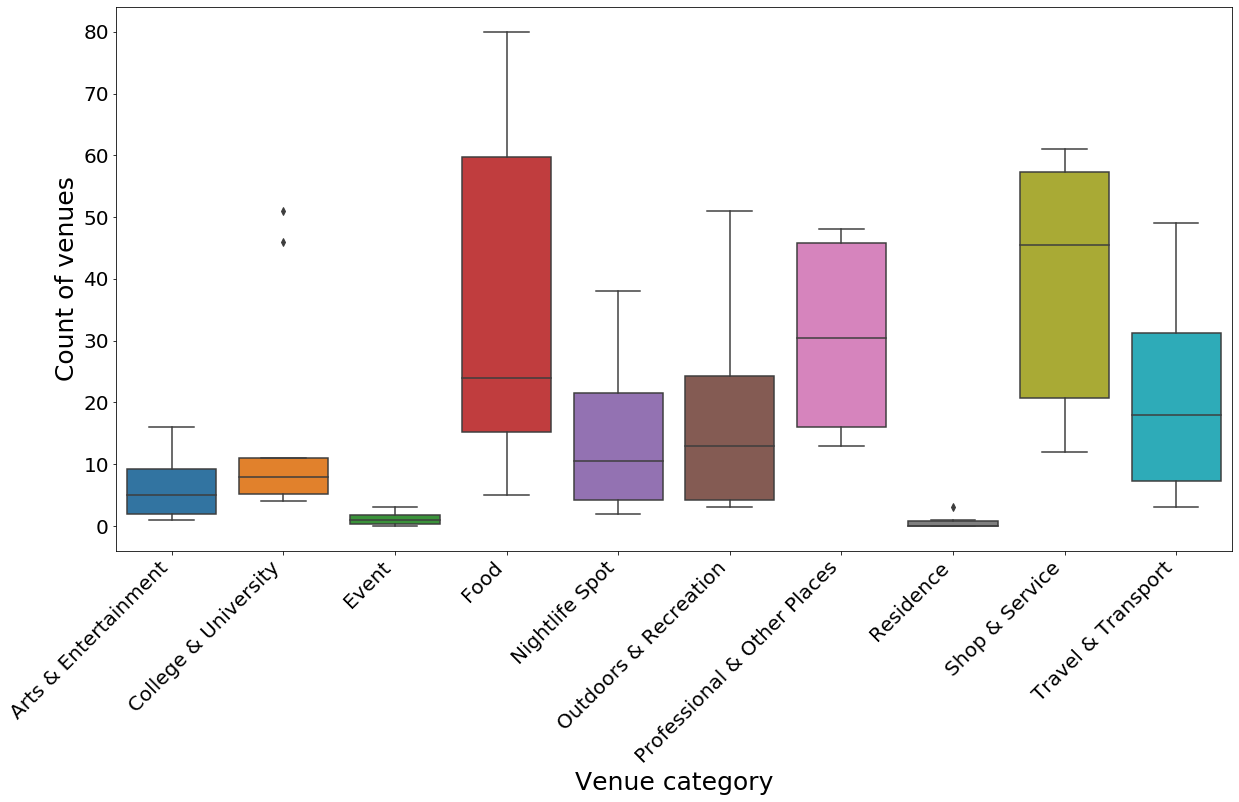

In [16]:
plt.figure(figsize=(20, 10))
plt.xticks(rotation='vertical')
sns.boxplot

ax = sns.boxplot(data = aachen_venues_df[list(aachen_venues_df.columns)[4:]])
ax.set_ylabel('Count of venues', fontsize=25)
ax.set_xlabel('Venue category', fontsize=25)
ax.tick_params(labelsize=20)
plt.xticks(rotation=45, ha='right')

plt.show()

Drop the lower count venues to have a better analysis

In [17]:
aachen_venues_df.drop(['Event', 'Residence'], axis=1, inplace=True)

Normalize the data using MinMaxScaler

In [18]:
from sklearn.preprocessing import MinMaxScaler

X = aachen_venues_df.values[:,4:]
cluster_dataset = MinMaxScaler().fit_transform(X)

In [19]:
cluster_df = pd.DataFrame(cluster_dataset)
cluster_df.columns = [c for c in list(aachen_venues_df.columns)[4:]]
cluster_df.head()

,Arts & Entertainment,College & University,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Shop & Service,Travel & Transport
0,0.600000,0.893617,0.760000,0.777778,0.250000,1.000000,0.959184,0.326087
1,0.733333,0.148936,0.813333,0.555556,0.395833,0.942857,1.000000,0.630435
2,0.400000,0.106383,0.640000,0.388889,0.458333,0.857143,0.979592,0.565217
3,0.066667,0.021277,0.146667,0.055556,0.166667,0.142857,0.693878,0.326087
4,0.400000,0.148936,0.320000,0.500000,0.562500,0.914286,0.673469,1.000000


Plotting the scaled data

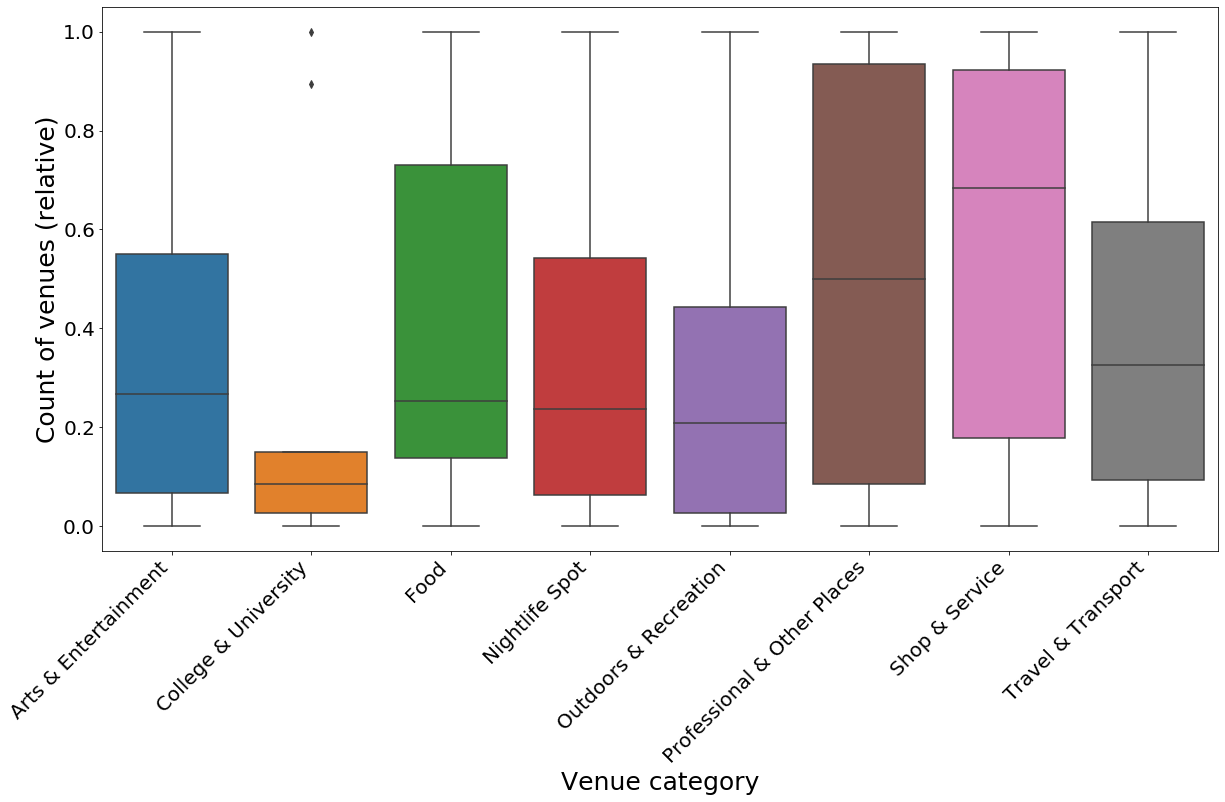

In [20]:
plt.figure(figsize=(20, 10))
#plt.xticks(rotation='vertical')
sns.boxplot

ax = sns.boxplot(data = cluster_df)
ax.set_ylabel('Count of venues (relative)', fontsize=25)
ax.set_xlabel('Venue category', fontsize=25)
ax.tick_params(labelsize=20)
plt.xticks(rotation=45, ha='right')

plt.show()

#### Clustering the areas with different postalcodes

Elbow method can be used to find the number of clusters possible for different postal codes

D:\Anaconda\envs\datascience\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


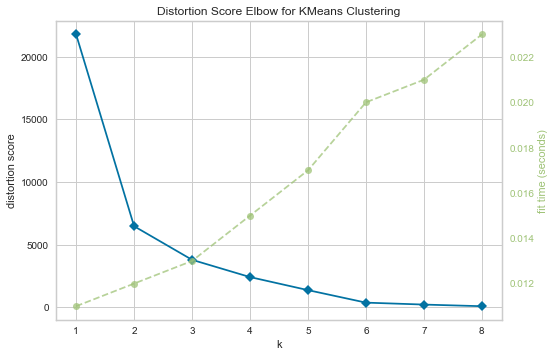

In [21]:
from yellowbrick.cluster import KElbowVisualizer

model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,9), locate_elbow=False)
visualizer.fit(X)
visualizer.show()

###### We can choose the number of clusters as 3 from the above elbow plot

##### Next task is to find the clusters

In [47]:
# set number of clusters
kclusters = 3

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(cluster_df)

kmeans_labels = kmeans.labels_

aachen_clusters_df = aachen_venues_df.copy()
aachen_clusters_df['Cluster'] = kmeans_labels
aachen_clusters_minmax_df = cluster_df.copy()
aachen_clusters_minmax_df['Cluster'] = kmeans_labels
aachen_clusters_minmax_df['PostalCode'] = aachen_venues_df['postcode']
# aachen_clusters_minmax_df['Latitude'] = aachen_venues_df['lat']
# aachen_clusters_minmax_df['Longitude'] = aachen_venues_df['lng']
aachen_clusters_minmax_df

,Arts & Entertainment,College & University,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Shop & Service,Travel & Transport,Cluster,PostalCode
0,0.600000,0.893617,0.760000,0.777778,0.250000,1.000000,0.959184,0.326087,2,"52062,Aachen"
1,0.733333,0.148936,0.813333,0.555556,0.395833,0.942857,1.000000,0.630435,0,"52064,Aachen"
2,0.400000,0.106383,0.640000,0.388889,0.458333,0.857143,0.979592,0.565217,0,"52066,Aachen"
3,0.066667,0.021277,0.146667,0.055556,0.166667,0.142857,0.693878,0.326087,1,"52068,Aachen"
4,0.400000,0.148936,0.320000,0.500000,0.562500,0.914286,0.673469,1.000000,0,"52070,Aachen"
5,0.000000,0.042553,0.000000,0.083333,0.020833,0.000000,0.040816,0.065217,1,"52072,Aachen"
6,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.816327,1.000000,2,"52074,Aachen"
7,0.066667,0.021277,0.133333,0.083333,0.041667,0.028571,0.081633,0.000000,1,"52076,Aachen"
8,0.133333,0.063830,0.186667,0.055556,0.020833,0.085714,0.469388,0.086957,1,"52078,Aachen"
9,0.066667,0.000000,0.053333,0.000000,0.000000,0.085714,0.000000,0.108696,1,"52080,Aachen"


Plotting the venue counts for each cluster

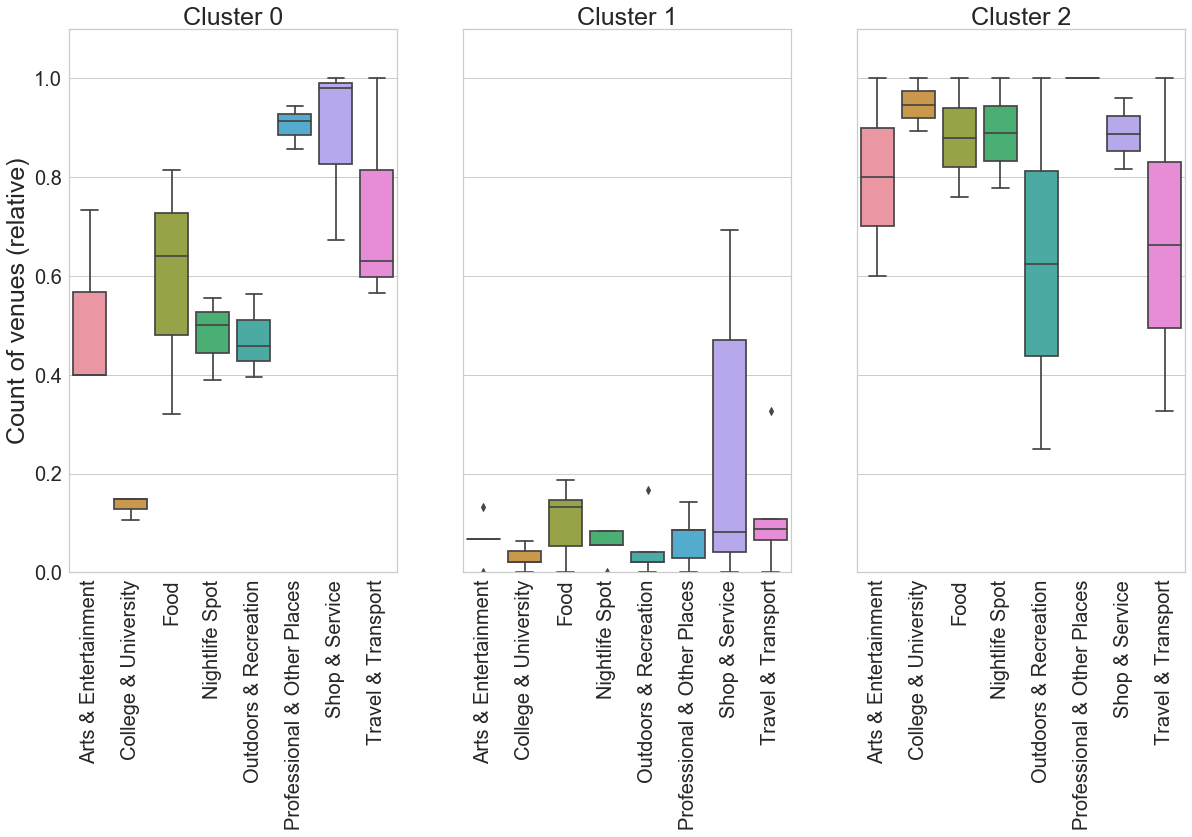

In [48]:
import matplotlib.ticker as ticker

fig, axes = plt.subplots(1,kclusters, figsize=(20, 10), sharey=True)

axes[0].set_ylabel('Count of venues (relative)', fontsize=25)
#plt.set_xlabel('Venue category', fontsize='x-large')

for k in range(kclusters):
    #Set same y axis limits
    axes[k].set_ylim(0,1.1)
    axes[k].xaxis.set_label_position('top')
    axes[k].set_xlabel('Cluster ' + str(k), fontsize=25)
    axes[k].tick_params(labelsize=20)
    plt.sca(axes[k])
    plt.xticks(rotation='vertical')
    sns.boxplot(data = aachen_clusters_minmax_df[aachen_clusters_minmax_df['Cluster'] == k].drop('Cluster',1), ax=axes[k])

plt.show()

### Results

From the above clustering we can see that aachen's regions are separated in 3 clusters. 

Analysis for the clusters are as follows

###### * Cluster 0 (52064, 52066, 52070) for Working People (31-50) 

These regions have less venues for College and University. But high number of venues in category professional & other places along with decent number of night spots. So this place might be a better choice for middle aged people, who are working professionals and are engaged into moderate amount of night life.

###### * Cluster 1 (52068, 52072, 52076, 52078, 52080) for Older citizens (50+)

These regions are low in number for all kinds venues except for shops and service which are low to moderate in number. This shows that there will be less noise in these regions which might be perfect for older citizens.

###### * Cluster 2 (52062, 52074) for Students (18-30)

These regions are highly populated with all kinds of venues especially college & university. Hence, this cluster is best for young adults, who are mostly students.


#### Suggestions

1. More data could be used for this problem statement to get better results, as foursquare data is not adequate to show all the needs of people.

2. Other data resources can be obtained from the city data base.

3. More detailed analysis could be done depending on prices of houses and prices of venues available in each region.